<a href="https://colab.research.google.com/github/Dyakonov/python_hacks/blob/master/dj_AE_20220318.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Автокодировщик

* Дьяконов Александр, 2022 (немного взято из pytorch-Deep-Learning-master-atcold)

In [1]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Датасет

In [2]:
input_size  = 28*28   # размер изображения
output_size = 10      # 10 классов

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15912619.02it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 480256.96it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 905417.88it/s] 


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3124574.18it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



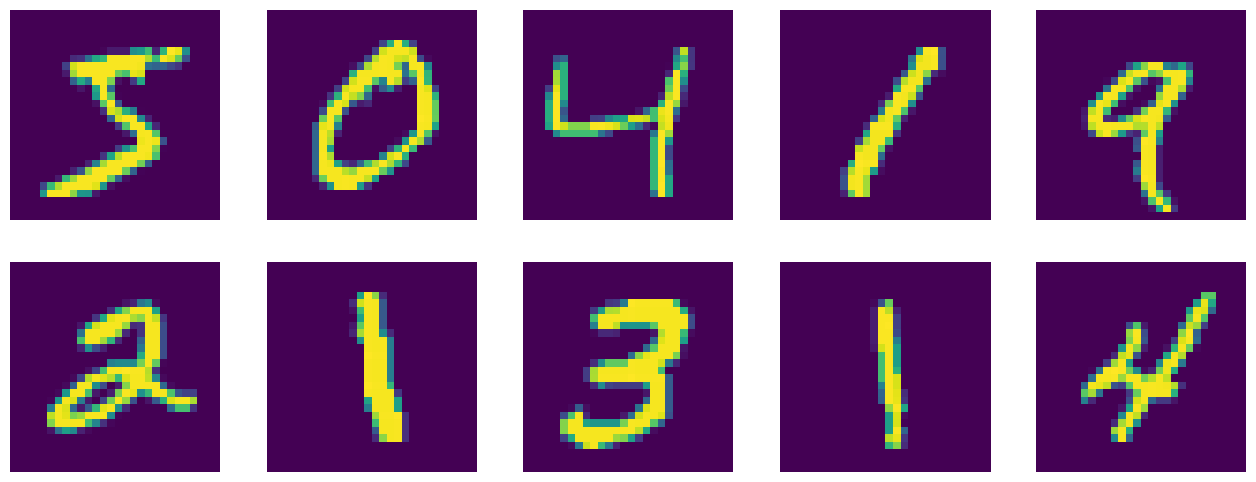

In [3]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

## Простой автокодировщик

In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 2), # тут можно и нужно увеличить 2
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 28 * 28),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder().to(device)
criterion = nn.MSELoss()

In [5]:
def get_n_params(model):
    """
    число параметров
    """
    np = 0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

get_n_params(model)

3922

In [6]:
# Convert vector to image

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.view(x.size(0), 28, 28)
    return x

# Displaying routine

def display_images(in_, out, n=1):
    for N in range(n):
        if in_ is not None:
            in_pic = to_img(in_.cpu().data)
            plt.figure(figsize=(18, 6))
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = to_img(out.cpu().data)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')

epoch [1/10], loss:0.7986
epoch [2/10], loss:0.6944
epoch [3/10], loss:0.6643
epoch [4/10], loss:0.6518
epoch [5/10], loss:0.6433
epoch [6/10], loss:0.6379
epoch [7/10], loss:0.6333
epoch [8/10], loss:0.6292
epoch [9/10], loss:0.6248
epoch [10/10], loss:0.6210


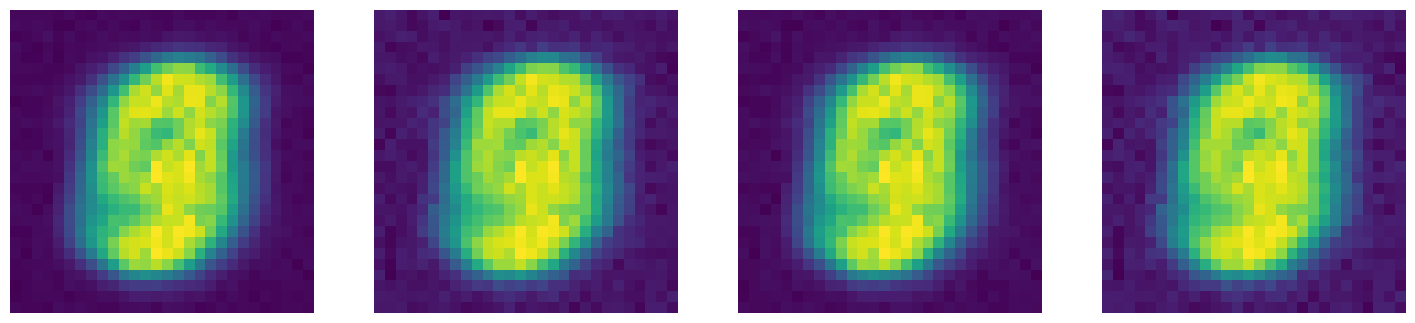

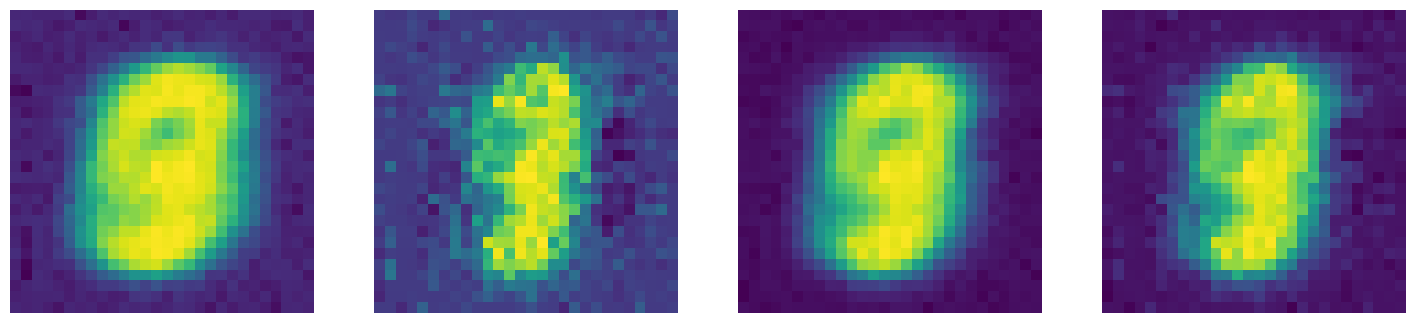

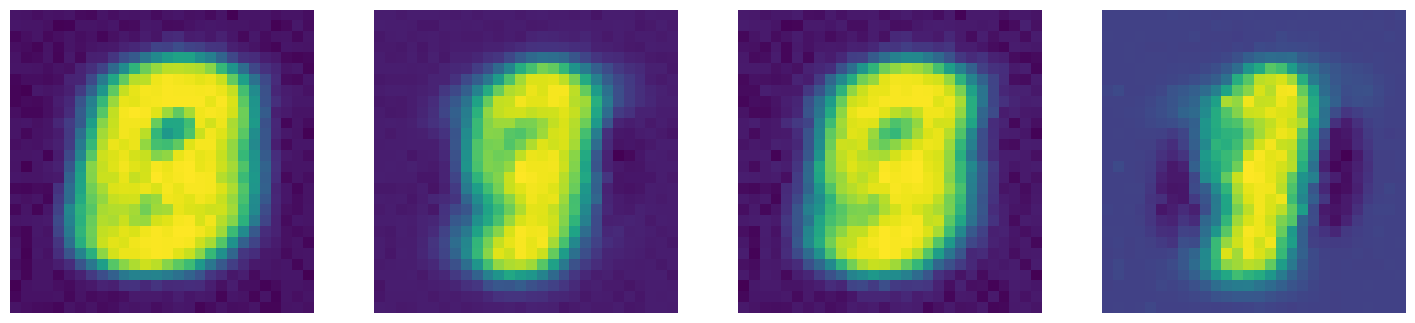

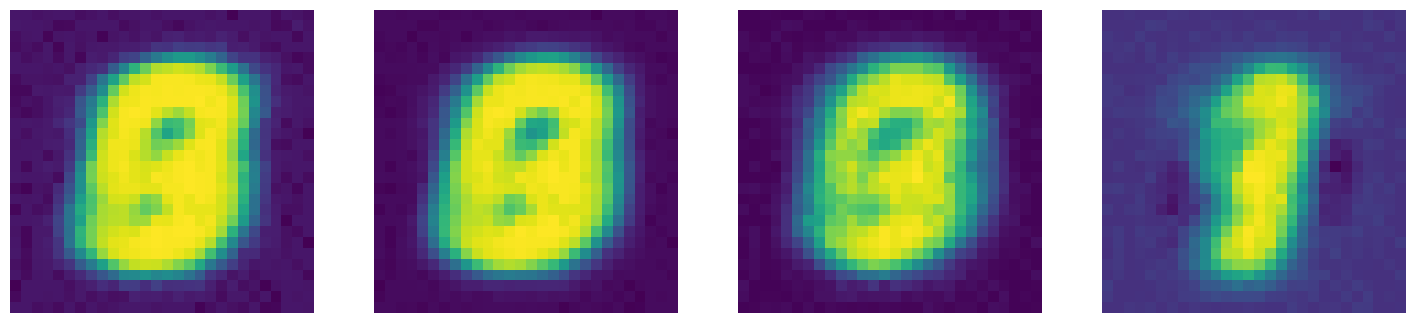

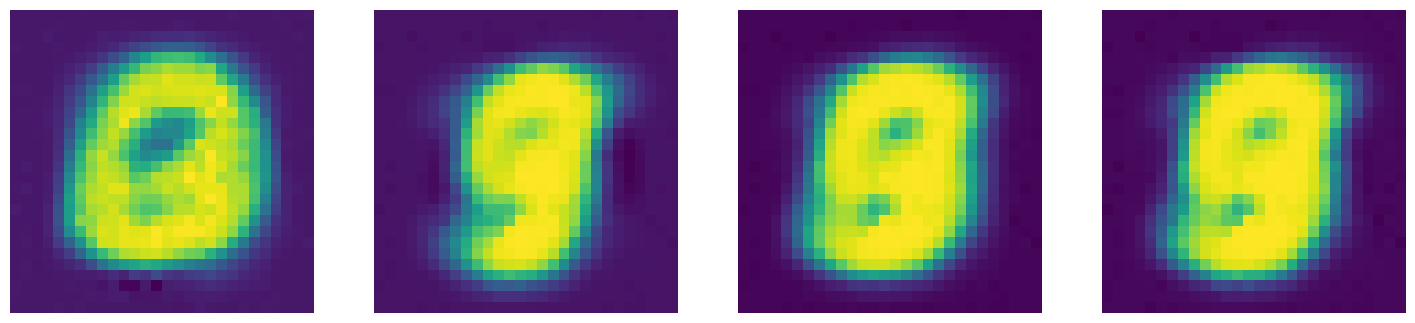

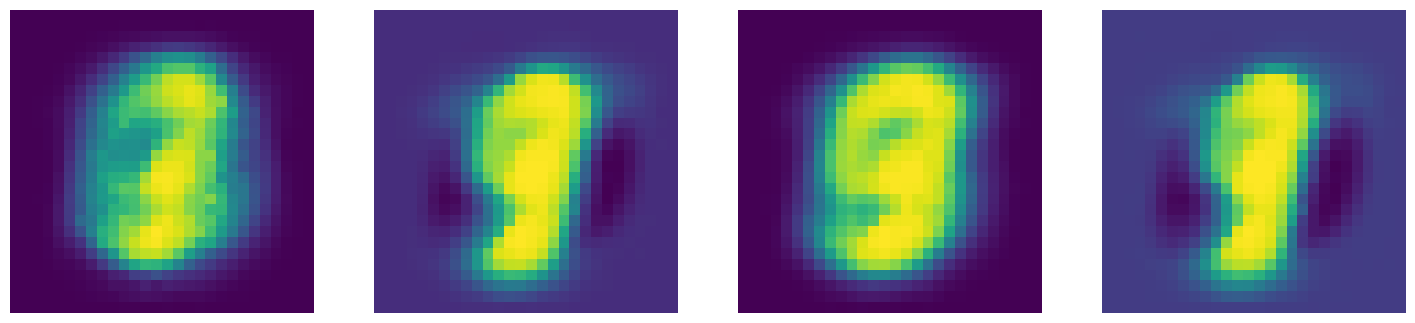

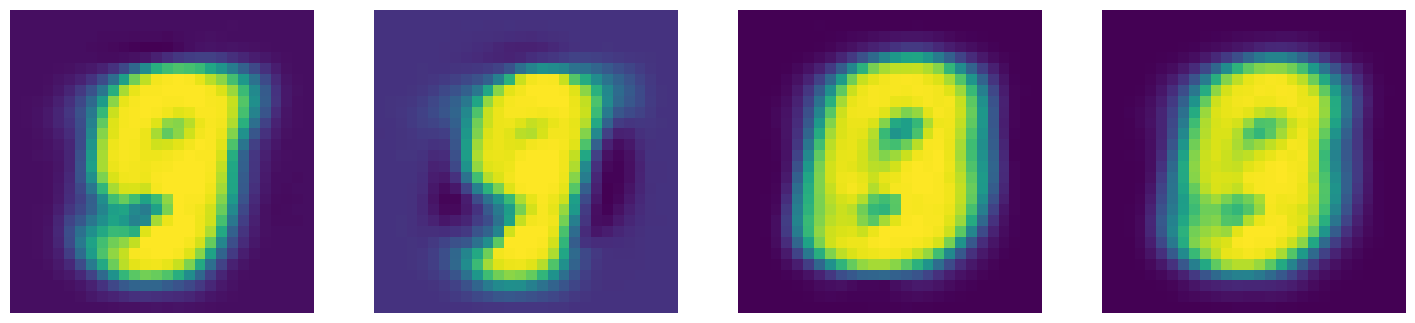

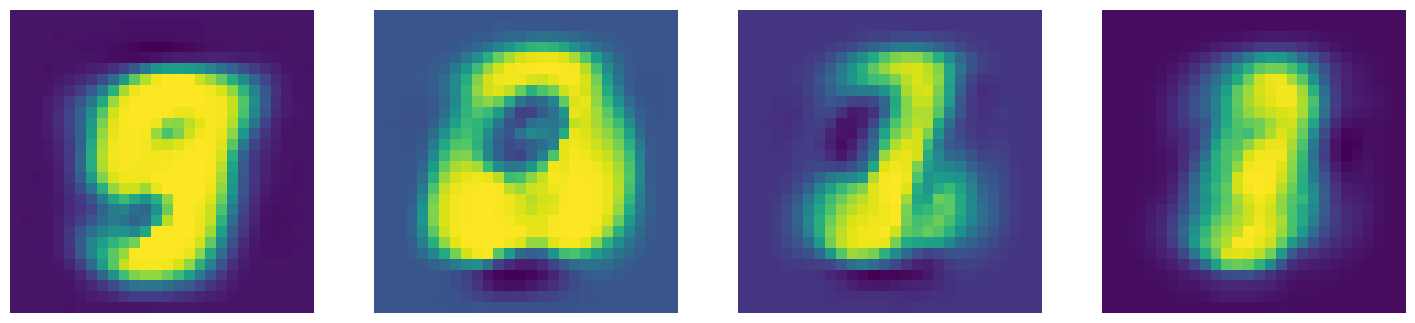

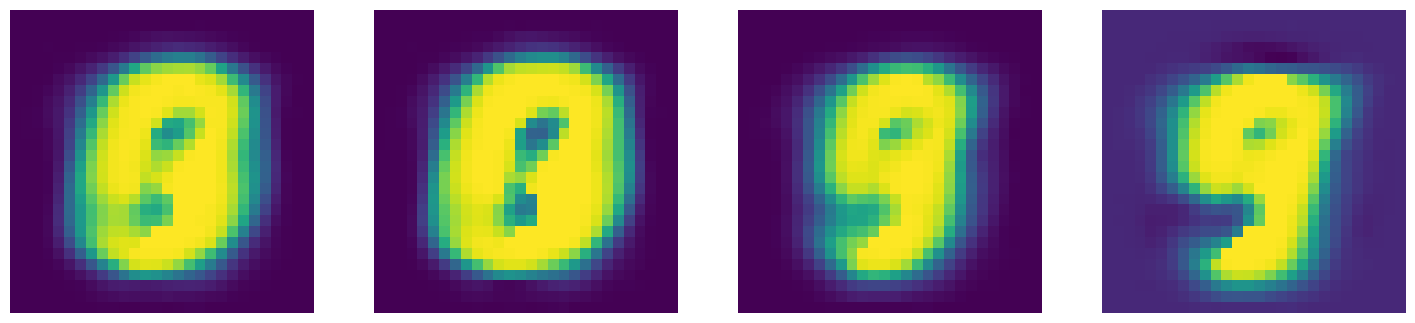

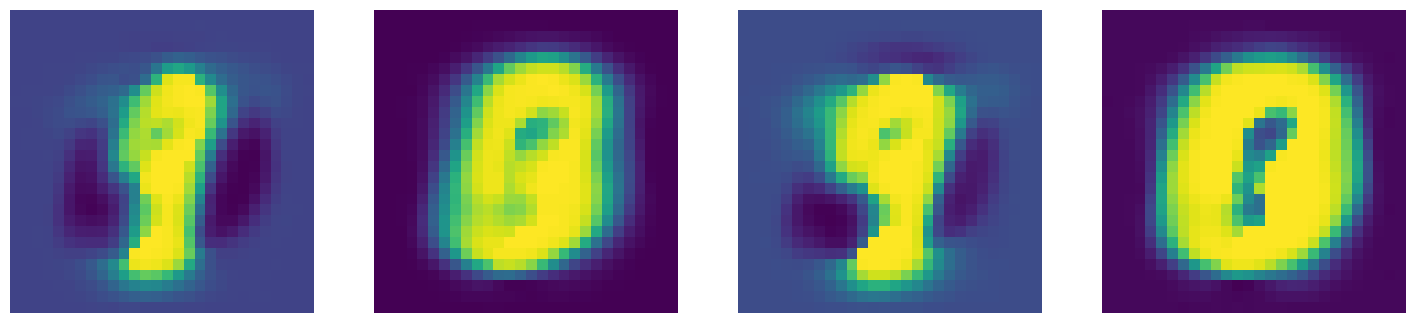

In [7]:
learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

num_epochs = 10

# do = nn.Dropout()  # comment out for standard AE
for epoch in range(num_epochs):
    total_loss = 0.0
    i_batch = 0
    for data in train_loader:
        img, tmp = data
        img = img.to(device)
        img = img.view(img.size(0), -1)
        # noise = do(torch.ones(img.shape)).to(device)
        # img_bad = (img * noise).to(device)  # comment out for standard AE
        # ===================forward=====================
        output = model(img)  # feed <img> (for std AE) or <img_bad> (for denoising AE)
        loss = criterion(output, img) # img.data
        total_loss += loss.item()
        i_batch += 1
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{total_loss/i_batch:.4f}')
    display_images(None, output)  # pass (None, output) for std AE, (img_bad, output) for denoising AE

In [ ]:
img.shape, output.shape

(torch.Size([32, 784]), torch.Size([32, 784]))

In [ ]:
tmp

tensor([1, 0, 2, 5, 5, 4, 1, 3, 6, 6, 3, 0, 5, 6, 0, 6, 9, 0, 5, 3, 2, 3, 5, 2,
        8, 3, 7, 9, 4, 6, 2, 6])

In [ ]:
# output[0,:]

tensor([-0.2437, -0.1268], device='cuda:0', grad_fn=<SliceBackward>)

## Латентное пространство на обучении

In [8]:
outputs = []
ys = []
for data in train_loader:
        img, y = data
        img = img.to(device)
        img = img.view(img.size(0), -1)
        output = model.encoder(img)  # feed <img> (for std AE) or <img_bad> (for denoising AE)
        outputs.append(output)
        ys.append(y)

In [9]:
outputs = torch.cat(outputs)
ys = torch.cat(ys)

In [10]:
outputs = outputs.detach().cpu().numpy()
ys = ys.detach().cpu().numpy()

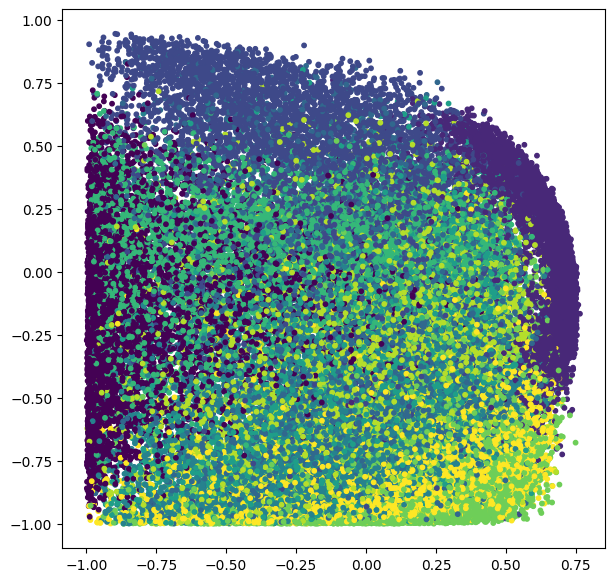

In [11]:
plt.figure(figsize=(7, 7))
plt.scatter(outputs[:,0], outputs[:,1], 10, ys)
# plt.legend()

### Латентное пространство на тесте

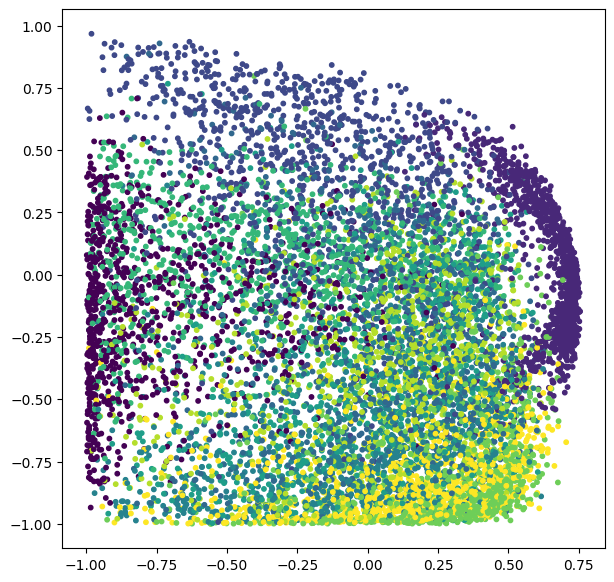

In [12]:
outputs = []
ys = []

for data in test_loader:
        img, y = data
        img = img.to(device)
        img = img.view(img.size(0), -1)
        output = model.encoder(img)  # feed <img> (for std AE) or <img_bad> (for denoising AE)
        outputs.append(output)
        ys.append(y)

outputs = torch.cat(outputs)
ys = torch.cat(ys)

outputs = outputs.detach().cpu().numpy()
ys = ys.detach().cpu().numpy()

plt.figure(figsize=(7, 7))
plt.scatter(outputs[:,0], outputs[:,1], 10, ys)
# plt.legend()

## Свёрточный кодировщик

In [33]:
class Myencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.convs = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=3, kernel_size=2, stride=1),
                                   nn.Tanh(),
                                   nn.Conv2d(in_channels=3, out_channels=6, kernel_size=4, stride=2),
                                   nn.Tanh(),
                                   nn.Conv2d(in_channels=6, out_channels=9, kernel_size=4, stride=2),
                                   nn.Tanh(),
                                   nn.Conv2d(in_channels=9, out_channels=12, kernel_size=3, stride=2),
                                   nn.Tanh(),
                                   nn.Conv2d(in_channels=12, out_channels=15, kernel_size=2, stride=1),
                                   nn.Tanh())
        self.lin = nn.Linear(15, 2)

    def forward(self, x):
        x = self.convs(x)
        x = self.lin(x.view(-1, 15))
        return x

class Mydecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.deconvs = nn.Sequential(nn.Tanh(),
                                   nn.ConvTranspose2d(in_channels=15, out_channels=12, kernel_size=2, stride=1),
                                   nn.Tanh(),
                                   nn.ConvTranspose2d(in_channels=12, out_channels=9, kernel_size=3, stride=2),
                                   nn.Tanh(),
                                   nn.ConvTranspose2d(in_channels=9, out_channels=6, kernel_size=4, stride=2),
                                   nn.Tanh(), # ниже изменил размеры, чтобы было 27х27
                                   nn.ConvTranspose2d(in_channels=6, out_channels=3, kernel_size=4, stride=2),
                                   nn.Tanh(),
                                   nn.ConvTranspose2d(in_channels=3, out_channels=1, kernel_size=3, stride=1),
                                   nn.Tanh()
                                   ) # было также nn.ZeroPad2d(padding=(0,1,0,1)) для приведения к 28х28
        self.lin2 = nn.Linear(2, 15)

    def forward(self, x):
        x = self.lin2(x)
        x = self.deconvs(x.view(-1, 15, 1, 1))
        return x

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Myencoder()
        self.decoder = Mydecoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder().to(device)
criterion = nn.MSELoss()

get_n_params(model)

5880

In [28]:
# НЕ ИСПОЛНЯТЬ!!!!

w = torch.rand(64, 28, 28).reshape(64,1,28,28)
#model = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=3),
#                      nn.Conv2d(in_channels=2, out_channels=4, kernel_size=3, stride=3),
#                      nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=3))
print (w.shape)
model = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=4, stride=2)
w = model(w)
print (w.shape)
model = nn.Conv2d(in_channels=2, out_channels=4, kernel_size=4, stride=2)
w = model(w)
print (w.shape)
model = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=2)
w = model(w)
print (w.shape)
model = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=2, stride=1)
w = model(w)
print (w.shape)

print ("----------")

###### w = torch.rand(10).reshape(1,10,1,1)
print (w.shape)
model = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=2, stride=1)
w = model(w)
print (w.shape)
model = nn.ConvTranspose2d(in_channels=8, out_channels=6, kernel_size=3, stride=2)
w = model(w)
print (w.shape)
model = nn.ConvTranspose2d(in_channels=6, out_channels=4, kernel_size=4, stride=2)
w = model(w)
print (w.shape)
model = nn.ConvTranspose2d(in_channels=4, out_channels=2, kernel_size=4, stride=2)
w = model(w)
print (w.shape)
model = nn.ConvTranspose2d(in_channels=2, out_channels=1, kernel_size=3, stride=1)
w = model(w)
print (w.shape)


#w = torch.rand(27, 27).reshape(1,1,27,27)
#model = nn.ZeroPad2d(padding=(0,1,0,1))
#model(w).shape
# ([1, 2, 13, 13])
# torch.Size([1, 4, 5, 5])
# torch.Size([1, 8, 2, 2])

torch.Size([64, 1, 28, 28])
torch.Size([64, 2, 13, 13])
torch.Size([64, 4, 5, 5])
torch.Size([64, 8, 2, 2])
torch.Size([64, 16, 1, 1])
----------
torch.Size([64, 16, 1, 1])
torch.Size([64, 8, 2, 2])
torch.Size([64, 6, 5, 5])
torch.Size([64, 4, 12, 12])
torch.Size([64, 2, 26, 26])
torch.Size([64, 1, 28, 28])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  ret

epoch [1/10], loss:0.8254
epoch [2/10], loss:0.6739
epoch [3/10], loss:0.6330
epoch [4/10], loss:0.6197
epoch [5/10], loss:0.6120
epoch [6/10], loss:0.6067
epoch [7/10], loss:0.6030
epoch [8/10], loss:0.5999
epoch [9/10], loss:0.5973
epoch [10/10], loss:0.5948


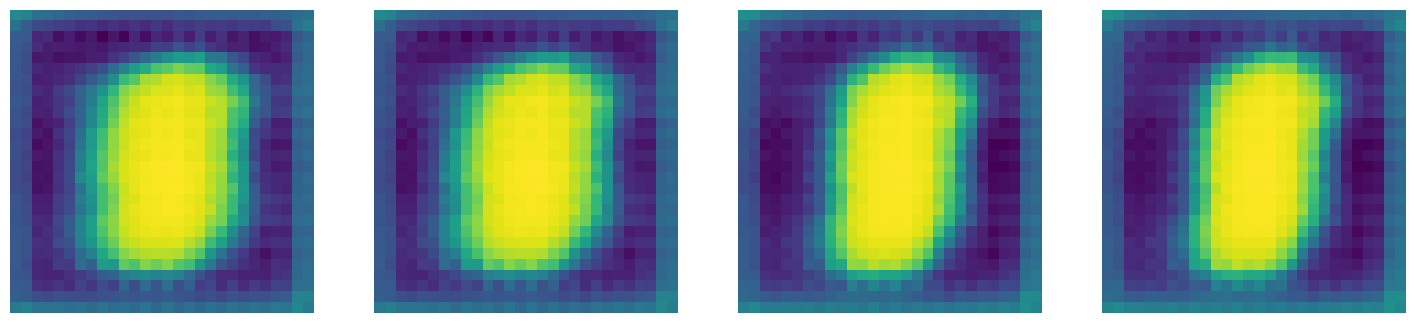

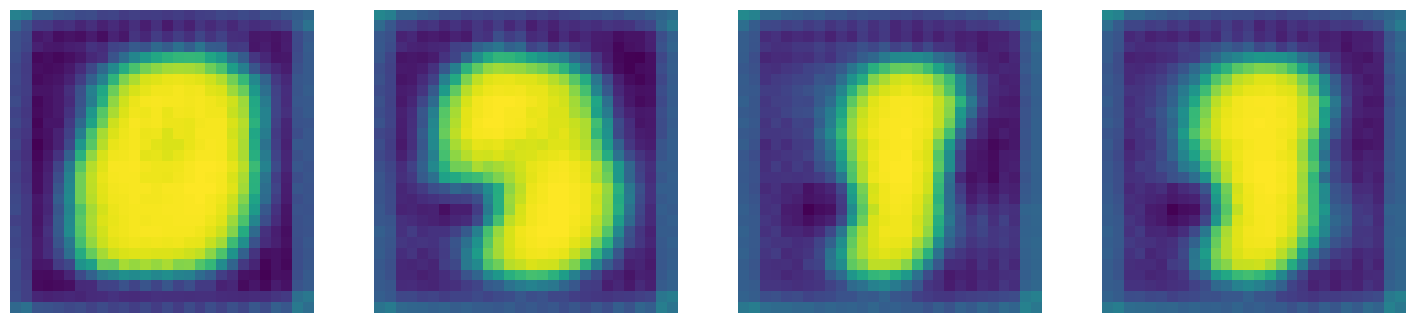

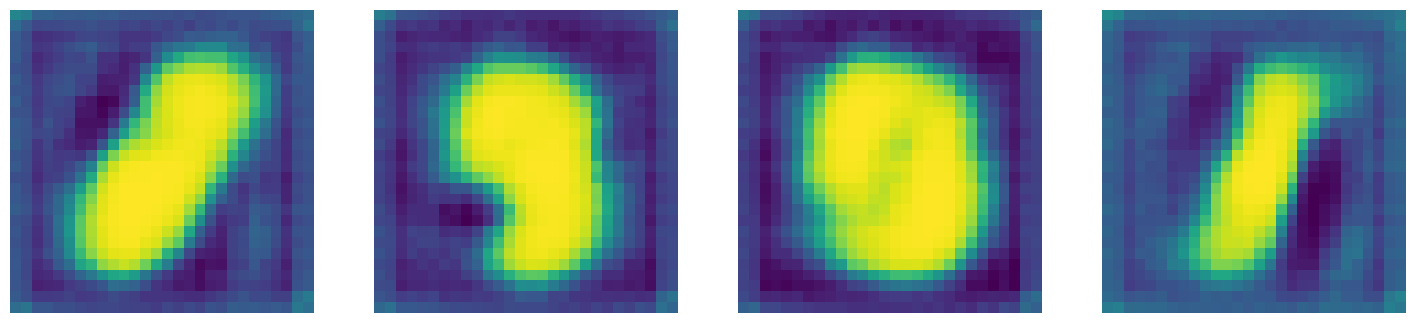

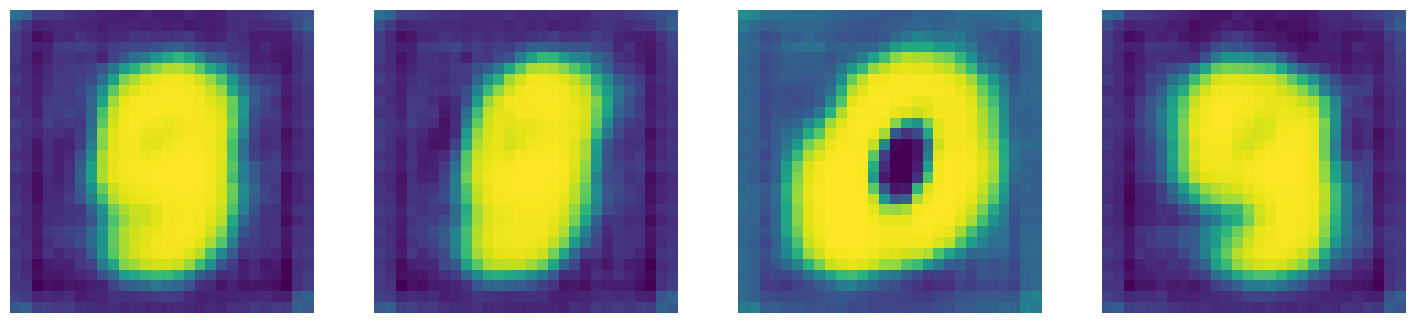

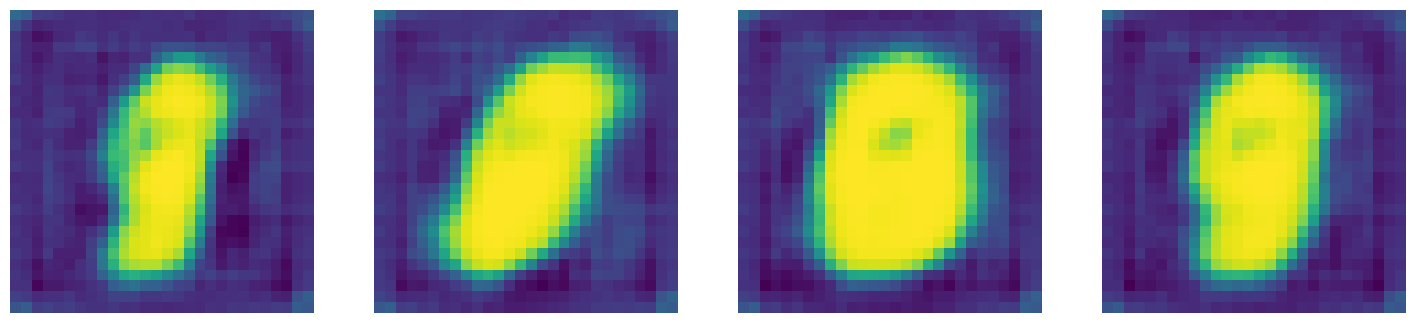

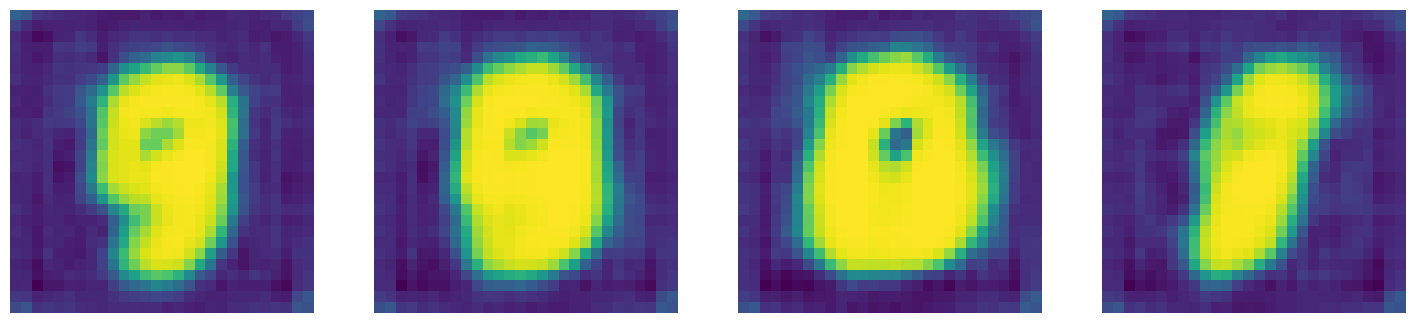

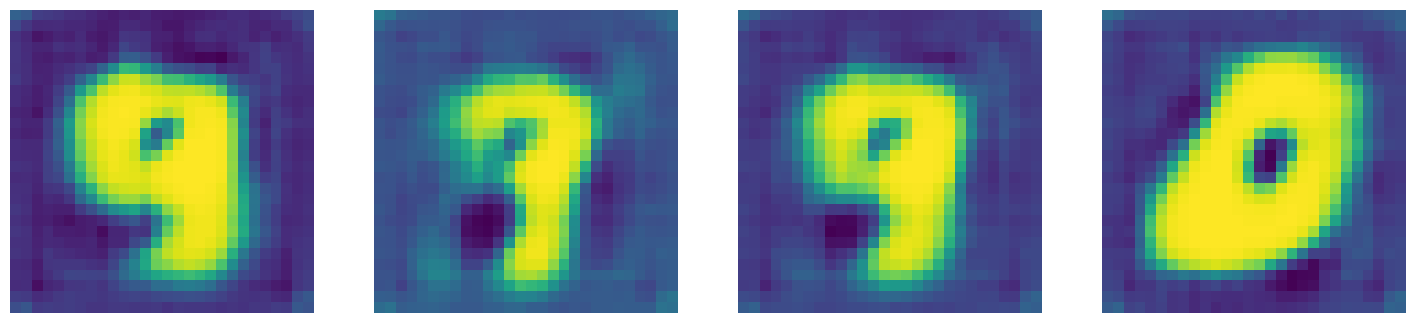

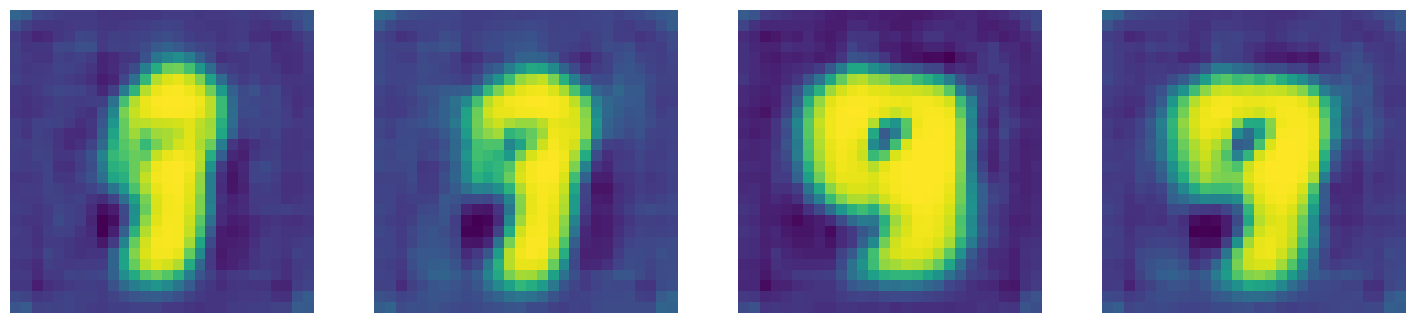

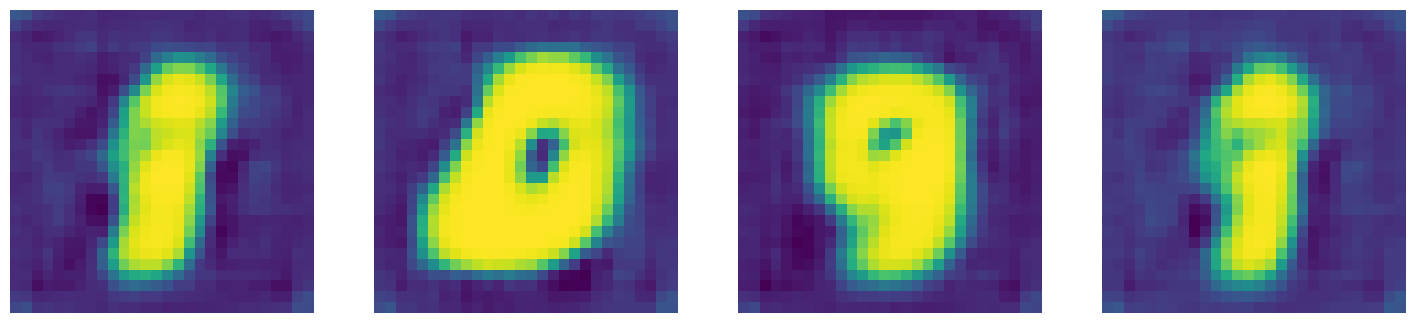

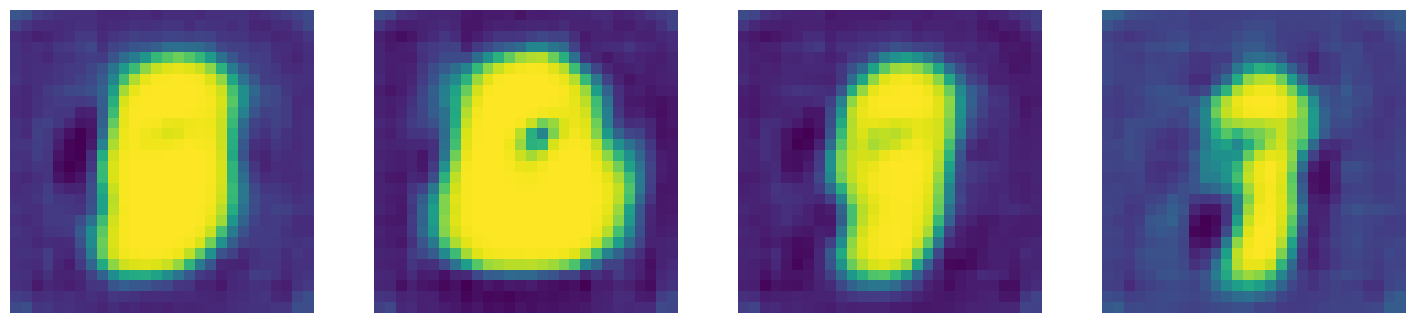

In [34]:
learning_rate = 1e-4

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

num_epochs = 10
# do = nn.Dropout()  # comment out for standard AE
for epoch in range(num_epochs):
    total_loss = 0
    i_batch = 0
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        # img = img.view(img.size(0), -1)
        # noise = do(torch.ones(img.shape)).to(device)
        # img_bad = (img * noise).to(device)  # comment out for standard AE
        # ===================forward=====================
        output = model(img)  # feed <img> (for std AE) or <img_bad> (for denoising AE)
        loss = criterion(output, img) # .data .view(-1, 1, 28*28)
        total_loss += loss.item()
        i_batch += 1
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{total_loss/i_batch:.4f}')
    display_images(None, output)  # pass (None, output) for std AE, (img_bad, output) for denoising AE

In [32]:
#output = model.encoder(img)
model

ConvTranspose2d(2, 1, kernel_size=(3, 3), stride=(1, 1))

In [20]:
img.shape

torch.Size([64, 1, 28, 28])

Из-за крупных последних свёрток - размыто.

In [21]:
output.shape, img.shape

(torch.Size([1000, 2]), torch.Size([64, 1, 28, 28]))

# Латентное пространство на тесте

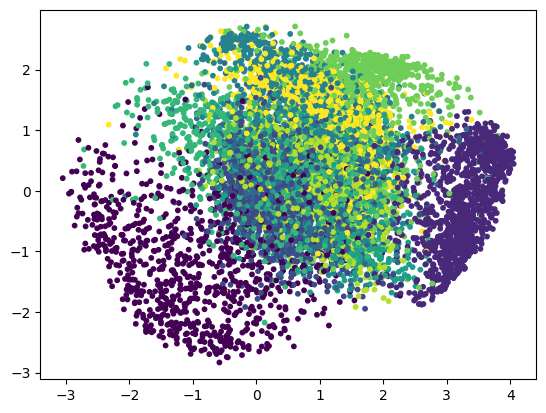

In [35]:
outputs = []
ys = []

for data in test_loader:
        img, y = data
        img = img.to(device)
        output = model.encoder(img)
        outputs.append(output)
        ys.append(y)

outputs = torch.cat(outputs)
ys = torch.cat(ys)

outputs = outputs.detach().cpu().numpy()
ys = ys.detach().cpu().numpy()

plt.scatter(outputs[:,0], outputs[:,1], 10, ys)
# plt.legend()

## Латентное пространство на обучении

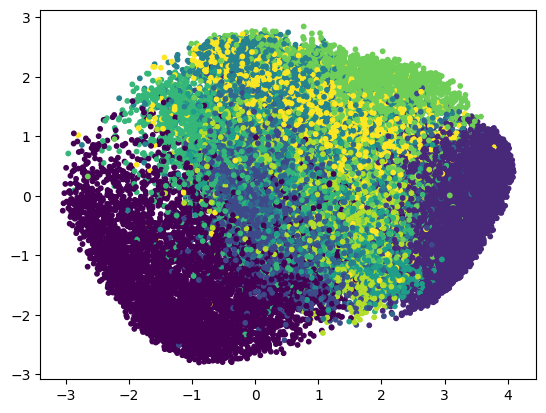

In [36]:
outputs = []
ys = []

for data in train_loader:
        img, y = data
        img = img.to(device)
        output = model.encoder(img)
        outputs.append(output)
        ys.append(y)

outputs = torch.cat(outputs)
ys = torch.cat(ys)

outputs = outputs.detach().cpu().numpy()
ys = ys.detach().cpu().numpy()

plt.scatter(outputs[:,0], outputs[:,1], 10, ys)
# plt.legend()

## Порождение объекта

(-0.5, 27.5, 27.5, -0.5)

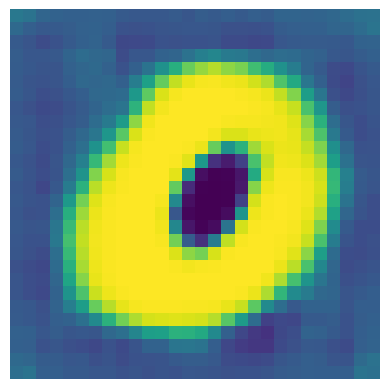

In [46]:
im_generated = model.decoder(torch.Tensor([-1, -1]).to(device)).view(28, 28).cpu().data

plt.imshow(im_generated)
plt.axis('off')

# Кодировщик с групповыми свёртками

* все большие свёртки - групповые, каналы увеличиваем 1х1-свёртками
* ещё в конце активацию убрали - это ещё уменьшает ошибку
* добавили BN

ещё тут можно связи прокинуть

In [ ]:
class MyGroupEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.convs = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, groups=1), # 3x3
                                   nn.BatchNorm2d(2),
                                   nn.Tanh(),
                                   nn.Conv2d(in_channels=2, out_channels=4, kernel_size=1), # 1x1
                                   nn.BatchNorm2d(4),
                                   nn.Tanh(),
                                   nn.Conv2d(in_channels=4, out_channels=4, kernel_size=3, groups=4), # 3x3
                                   nn.BatchNorm2d(4),
                                   nn.Tanh(),
                                   nn.Conv2d(in_channels=4, out_channels=8, kernel_size=1), # 1x1
                                   nn.BatchNorm2d(8),
                                   nn.Tanh(),
                                   nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, groups=8, stride=2),
                                   nn.BatchNorm2d(8),
                                   nn.Tanh(),
                                   nn.Conv2d(in_channels=8, out_channels=16, kernel_size=1), # 1x1
                                   nn.BatchNorm2d(16),
                                   nn.Tanh(),
                                   nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, groups=16, stride=2),
                                   nn.BatchNorm2d(16),
                                   nn.Tanh(),
                                   nn.Conv2d(in_channels=16, out_channels=32, kernel_size=1), # 1x1
                                   nn.BatchNorm2d(32),
                                   nn.Tanh(),
                                   nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, groups=32),
                                   nn.BatchNorm2d(32),
                                   nn.Tanh())
        self.lin = nn.Linear(32, 2)

    def forward(self, x):
        x = self.convs(x)
        x = self.lin(x.view(-1, 32))
        return x

class MyGroupDecoder(nn.Module):
    def __init__(self):
        super().__init__()
#         self.deconvs = nn.Sequential(nn.Tanh(),
#                                    nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=5, groups=32),
#                                    nn.Tanh(),
#                                    nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=1),
#                                    nn.Tanh(),
#                                    nn.ConvTranspose2d(in_channels=16, out_channels=16, kernel_size=3, groups=16, stride=2),
#                                    nn.Tanh(),
#                                    nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=1), # 1x1
#                                    nn.Tanh(),
#                                    nn.ConvTranspose2d(in_channels=8, out_channels=8, kernel_size=3, groups=8, stride=2),
#                                    nn.Tanh(),
#                                    nn.ConvTranspose2d(in_channels=8, out_channels=4, kernel_size=1), # 1x1,
#                                    nn.Tanh(),
#                                    nn.ConvTranspose2d(in_channels=4, out_channels=4, kernel_size=3, groups=4),
#                                    nn.Tanh(),
#                                    nn.ConvTranspose2d(in_channels=4, out_channels=2, kernel_size=1),
#                                    nn.Tanh(),
#                                    nn.ConvTranspose2d(in_channels=2, out_channels=1, kernel_size=3, groups=1),
#                                    nn.Tanh())

        # пришлось немного испортить модель, чтобы совпадали размеры
        self.deconvs = model = nn.Sequential(nn.BatchNorm2d(32),
                                             nn.Tanh(),
                                   nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=6, groups=32),
                                             nn.BatchNorm2d(32),
                                   nn.Tanh(),
                                   nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=1),
                                             nn.BatchNorm2d(16),
                                   nn.Tanh(),
                                   nn.ConvTranspose2d(in_channels=16, out_channels=16, kernel_size=3, groups=16, stride=2),
                                   nn.BatchNorm2d(16),
                                             nn.Tanh(),
                                   nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=1), # 1x1
                                   nn.BatchNorm2d(8),
                                             nn.Tanh(),
                                   nn.ConvTranspose2d(in_channels=8, out_channels=8, kernel_size=2, groups=8, stride=2),
                                   nn.BatchNorm2d(8),
                                             nn.Tanh(),
                                   nn.ConvTranspose2d(in_channels=8, out_channels=4, kernel_size=1), # 1x1,
                                   nn.BatchNorm2d(4),
                                             nn.Tanh(),
                                   nn.ConvTranspose2d(in_channels=4, out_channels=4, kernel_size=2, groups=4),
                                   nn.BatchNorm2d(4),
                                             nn.Tanh(),
                                   nn.ConvTranspose2d(in_channels=4, out_channels=2, kernel_size=1),
                                   nn.BatchNorm2d(2),
                                             nn.Tanh(),
                                   nn.ConvTranspose2d(in_channels=2, out_channels=1, kernel_size=2, groups=1),
                                   # nn.Tanh(),
                     )
        self.lin2 = nn.Linear(2, 32)

    def forward(self, x):
        x = self.lin2(x)
        x = self.deconvs(x.view(-1, 32, 1, 1))
        return x

class GroupAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = MyGroupEncoder()
        self.decoder = MyGroupDecoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = GroupAutoencoder().to(device)
criterion = nn.MSELoss()

get_n_params(model)

4645

In [ ]:
# w = torch.rand(28, 28).reshape(1,1,28,28)

# model = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, groups=1), # 3x3
#                                    nn.Tanh(),
#                                    nn.Conv2d(in_channels=2, out_channels=4, kernel_size=1), # 1x1
#                                    nn.Tanh(),
#                                    nn.Conv2d(in_channels=4, out_channels=4, kernel_size=3, groups=4), # 3x3
#                                    nn.Tanh(),
#                                    nn.Conv2d(in_channels=4, out_channels=8, kernel_size=1), # 1x1
#                                    nn.Tanh(),
#                                    nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, groups=8, stride=2),
#                                    nn.Tanh(),
#                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=1), # 1x1
#                                    nn.Tanh(),
#                                    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, groups=16, stride=2),
#                                    nn.Tanh(),
#                                    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=1), # 1x1
#                                    nn.Tanh(),
#                                    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, groups=32),
#                                    nn.Tanh(),
#                                    #nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1), # 1x1
#                                    #nn.Tanh(),
#                     )

# w = torch.rand(1, 32).reshape(1,32,1,1)

# model = nn.Sequential(nn.Tanh(),
#                                    nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=6, groups=32),
#                                    nn.Tanh(),
#                                    nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=1),
#                                    nn.Tanh(),
#                                    nn.ConvTranspose2d(in_channels=16, out_channels=16, kernel_size=3, groups=16, stride=2),
#                                    nn.Tanh(),
#                                    nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=1), # 1x1
#                                    nn.Tanh(),
#                                    nn.ConvTranspose2d(in_channels=8, out_channels=8, kernel_size=2, groups=8, stride=2),
#                                    nn.Tanh(),
#                                    nn.ConvTranspose2d(in_channels=8, out_channels=4, kernel_size=1), # 1x1,
#                                    nn.Tanh(),
#                                    nn.ConvTranspose2d(in_channels=4, out_channels=4, kernel_size=2, groups=4),
#                                    nn.Tanh(),
#                                    nn.ConvTranspose2d(in_channels=4, out_channels=2, kernel_size=1),
#                                    nn.Tanh(),
#                                    nn.ConvTranspose2d(in_channels=2, out_channels=1, kernel_size=2, groups=1),
#                                    # nn.Tanh(),
#                      )
# nn.Conv2d(in_channels=4, out_channels=8, kernel_size=1, groups=4)
# nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1)
# w = model(w)
# w.shape

torch.Size([1, 1, 28, 28])

In [ ]:
get_n_params(model)

4645

epoch [1/10], loss:0.6732
epoch [2/10], loss:0.5332
epoch [3/10], loss:0.5105
epoch [4/10], loss:0.5002
epoch [5/10], loss:0.4939
epoch [6/10], loss:0.4885
epoch [7/10], loss:0.4856
epoch [8/10], loss:0.4825
epoch [9/10], loss:0.4802
epoch [10/10], loss:0.4770


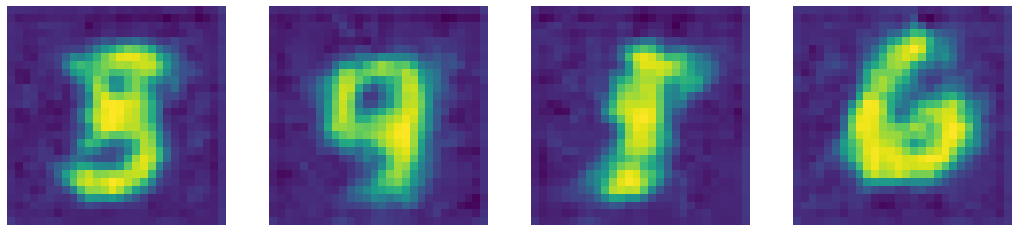

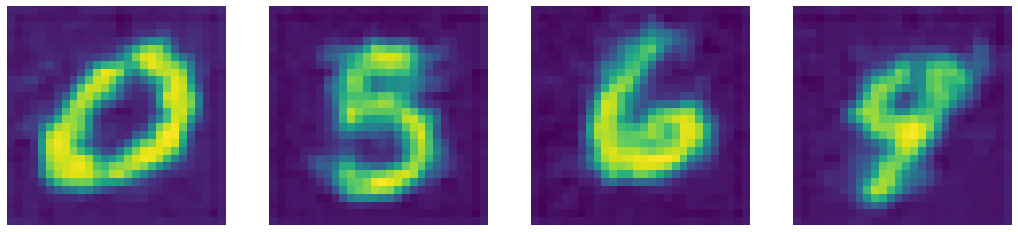

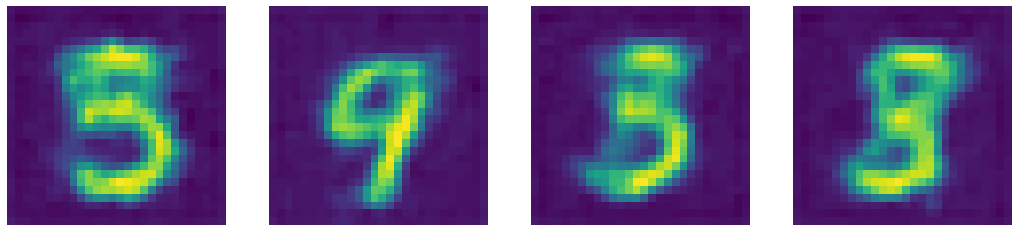

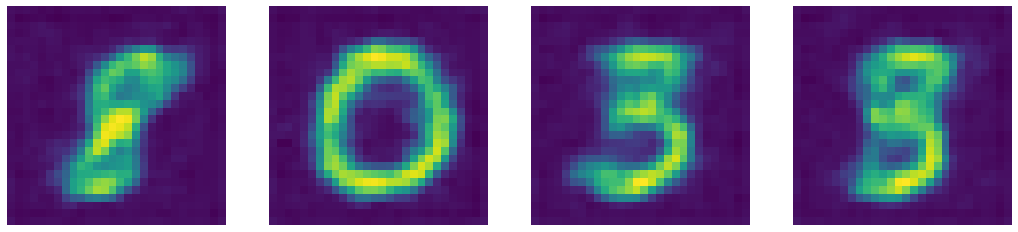

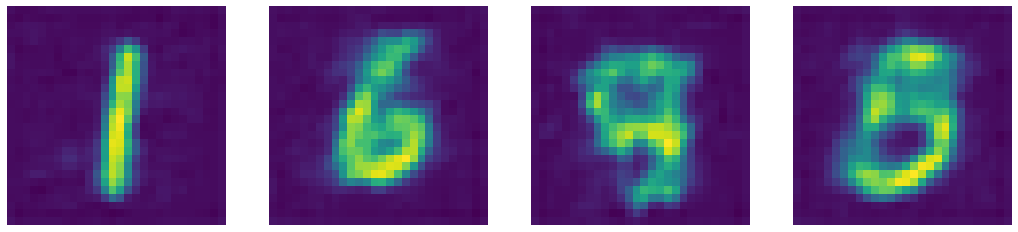

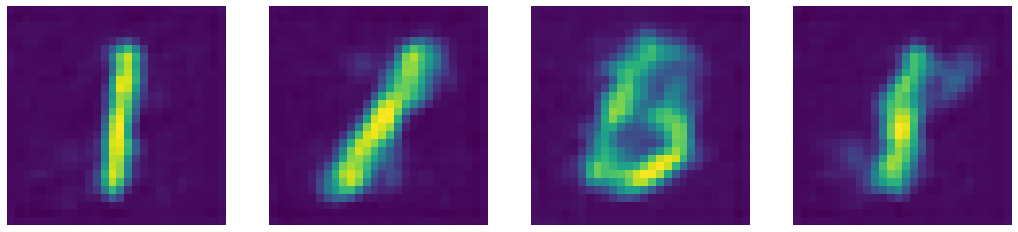

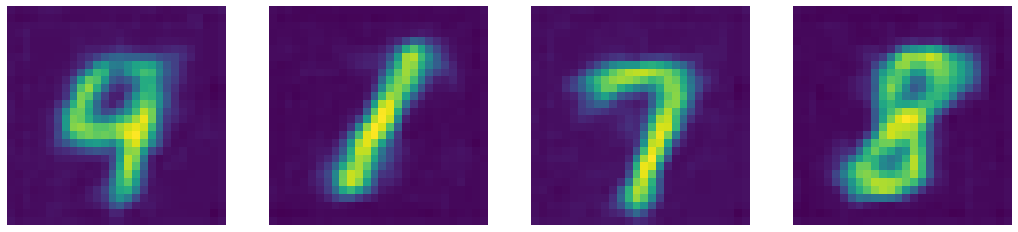

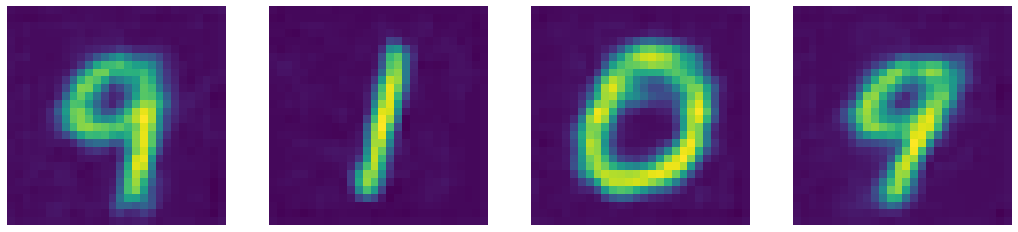

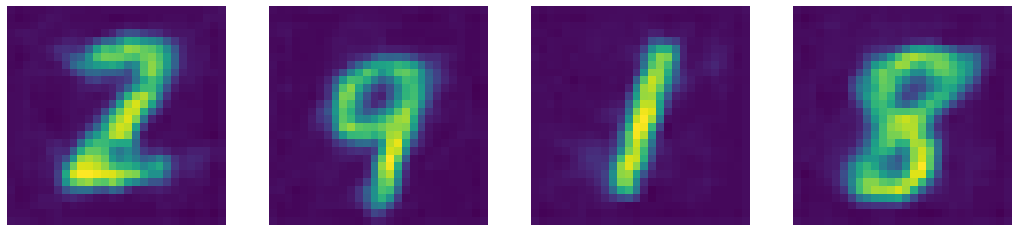

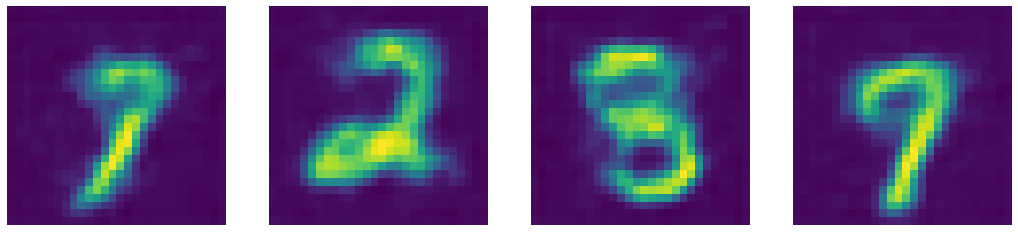

In [ ]:
learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

num_epochs = 10
# do = nn.Dropout()  # comment out for standard AE
for epoch in range(num_epochs):
    total_loss = 0
    i_batch = 0
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        # img = img.view(img.size(0), -1)
        # noise = do(torch.ones(img.shape)).to(device)
        # img_bad = (img * noise).to(device)  # comment out for standard AE
        # ===================forward=====================
        output = model(img)  # feed <img> (for std AE) or <img_bad> (for denoising AE)
        loss = criterion(output, img) # .data .view(-1, 1, 28*28)
        total_loss += loss.item()
        i_batch += 1
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{total_loss/i_batch:.4f}')
    display_images(None, output)  # pass (None, output) for std AE, (img_bad, output) for denoising AE

In [ ]:
output.shape, img.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32, 1, 28, 28]))

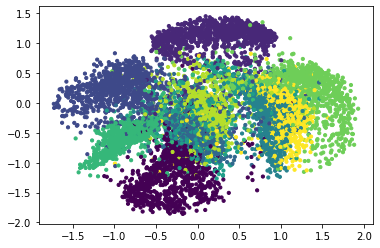

In [ ]:
outputs = []
ys = []

for data in test_loader:
        img, y = data
        img = img.to(device)
        output = model.encoder(img)
        outputs.append(output)
        ys.append(y)

outputs = torch.cat(outputs)
ys = torch.cat(ys)

outputs = outputs.detach().cpu().numpy()
ys = ys.detach().cpu().numpy()

plt.scatter(outputs[:,0], outputs[:,1], 10, ys)
# plt.legend()

In [ ]:
outputs = []
ys = []

for data in train_loader:
        img, y = data
        img = img.to(device)
        output = model.encoder(img)
        outputs.append(output)
        ys.append(y)

outputs = torch.cat(outputs)
ys = torch.cat(ys)

outputs = outputs.detach().cpu().numpy()
ys = ys.detach().cpu().numpy()

plt.scatter(outputs[:,0], outputs[:,1], 10, ys)
# plt.legend()

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 8.00 GiB total capacity; 6.21 GiB already allocated; 19.06 MiB free; 6.43 GiB reserved in total by PyTorch)